In [1]:
import cv2
import numpy as np
from PIL import Image

In [2]:
import chainer
from chainer.utils import type_check

In [3]:
from chainer import cuda

In [4]:
import chainer
from chainer import function
import chainer.functions as F
import chainer.links as L
from chainer import reporter
from chainer.dataset import convert

In [5]:
from rot import rotation3d

In [6]:
img0 = cv2.imread('model/ET/et000.jpg')
img1 = cv2.imread('model/ET/et003.jpg')

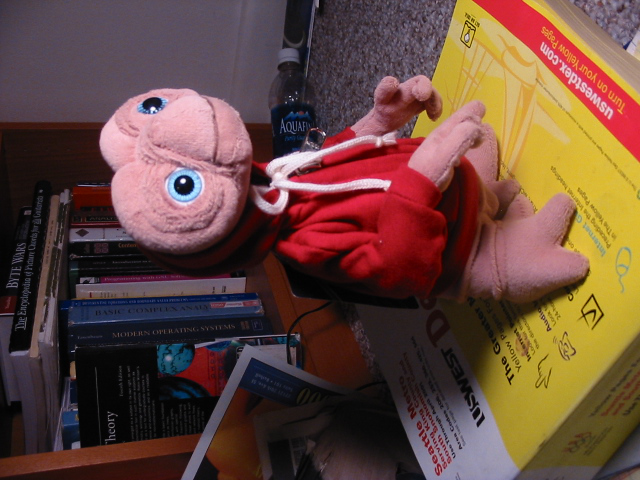

In [7]:
Image.fromarray(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))

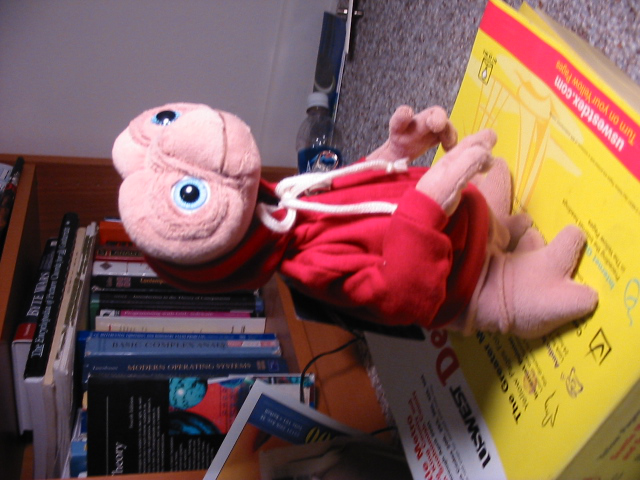

In [8]:
Image.fromarray(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

In [9]:
detector = cv2.xfeatures2d.SIFT_create(0, 8, 0.04, 12, 1.2)     
kp0, des0 = detector.detectAndCompute(img0, None)
kp1, des1 = detector.detectAndCompute(img1, None)

In [10]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des0,des1)

In [11]:
matches = sorted(matches, key = lambda x:x.distance)

In [12]:
img = img0.copy()
img = cv2.drawKeypoints(img0, kp0, None)

In [13]:
match_img = cv2.drawMatches(img0,kp0,img1,kp1,matches, None)

In [14]:
p0 = []
p1 = []
for m in matches:
    p0.append(kp0[m.queryIdx].pt)
    p1.append(kp1[m.trainIdx].pt)
p0 = np.array(p0)
p1 = np.array(p1)

In [15]:
matA = np.array([[700,0, 320], [0, 700, 240], [0, 0, 1]], dtype=np.float32)

In [16]:
E, mask = cv2.findEssentialMat(p0, p1, matA, method=cv2.RANSAC, prob=0.999, threshold=3.0)
_, rmat, tvec, _ = cv2.recoverPose(E, p0, p1)
rvec, _ = cv2.Rodrigues(rmat)

In [17]:
p0 = p0[mask.reshape(-1).astype(np.bool)]
p1 = p1[mask.reshape(-1).astype(np.bool)]

In [18]:
matches2 = []
for m, mc in zip(mask.reshape(-1), matches):
    if m == 1:
        matches2.append(mc)

In [19]:
len(matches2)

1525

In [20]:
match_img = cv2.drawMatches(img0,kp0,img1,kp1,matches2[:100], None)

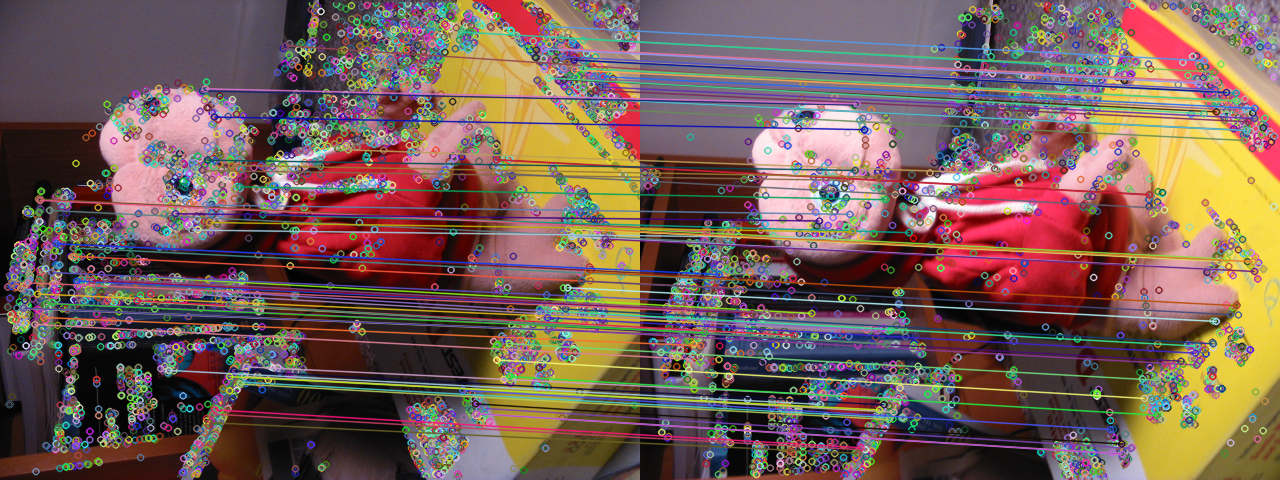

In [21]:
Image.fromarray(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))

In [22]:
pixels = img0[p0.astype(np.int32)[:,1], p0.astype(np.int32)[:,0]]

pl = np.dot(matA, np.eye(3, 4, dtype=np.float32))
pr = np.dot(matA, np.concatenate((rmat, tvec.reshape(3,1)), axis=1))
point4d = cv2.triangulatePoints(pl, pr, p0.T, p1.T).T
point3d = (point4d[:] / point4d[:,3:])[:,:3]

In [23]:
len(point3d)

1525

In [24]:
length = sorted(np.linalg.norm(point3d, axis=1))

In [25]:
length[5 * len(length) // 10]

50.792235697385124

In [26]:
idx = np.linalg.norm(point3d, axis=1) < length[5 * len(length) // 10]
point3d = point3d[idx]
pixels = pixels[idx]
p0 = p0[idx]
p1 = p1[idx]

In [27]:
class PreprocessedDataset(chainer.dataset.DatasetMixin):
    def __init__(self, p1, p2):
        self.p1 = p1.astype(np.float32)
        self.p2 = p2.astype(np.float32)

    def __len__(self):
        return len(self.p1)

    def get_example(self, i):
        return self.p1[i], self.p2[i]

In [28]:
data = PreprocessedDataset(p0, p1)

In [29]:
class Net(chainer.Chain):
    def __init__(self, matA, nb_data, rvec=None, tvec=None, points=None):
        super(Net, self).__init__()
        self.matA = matA.astype(np.float32)
        
        embd = None
        if rvec is not None and tvec is not None:
            embd = np.stack((rvec, tvec), axis=0)
            
        pts = None
        if points is not None:
            pts = points.reshape(-1)
            
        with self.init_scope():
            self.embd = L.EmbedID(2, 3, initialW=embd)
            self.points = L.EmbedID(1, 3 * nb_data, pts)

    def proj(self, x):
        xy, z = F.split_axis(x, (2,), axis=1)
        r = xy / F.broadcast_to(z, xy.shape)
        return r

    def __call__(self):
        xp = self.xp            
        matA = xp.asarray(self.matA)
        
        pts = self.points(xp.array([0], dtype=np.int32))
        pts = F.reshape(pts, (-1, 3))
            
        p0 = F.matmul(pts, matA, transa=False, transb=True)
        p0 = self.proj(p0)
        
        r = self.embd(xp.array([0], dtype=np.int32))
        r = F.reshape(r, (3,))
        
        t = self.embd(xp.array([1], dtype=np.int32))
        t = F.broadcast_to(t, pts.shape)
        
        rxt = rotation3d(pts, r) + t
        p1 = F.matmul(rxt, matA, transa=False, transb=True)
        p1 = self.proj(p1)

        return p0, p1

In [30]:
net = Net(matA, nb_data = len(data), rvec=rvec[:,0], tvec=tvec[:,0], points=point3d)

In [31]:
class loss_function(chainer.link.Chain):
    def __init__(self, predictor):
        super(loss_function, self).__init__(predictor=predictor)

    def __call__(self, p0, p1):
        q0, q1 = self.predictor()
        self.loss = F.mean_squared_error(p0, q0) + F.mean_squared_error(p1, q1)
        reporter.report({'loss': self.loss}, self)
        return self.loss

In [32]:
model = loss_function(net)

In [33]:
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [34]:
model(*convert.concat_examples(data[:], -1))

variable(0.29822689294815063)

In [35]:
data_iter = chainer.iterators.SerialIterator(data, len(data), shuffle=False)
data_count = len(data)

sum_loss = 0

while data_iter.epoch < 1000:
    batch = data_iter.next()
    x_array, y_array = convert.concat_examples(batch, -1)
    x = chainer.Variable(x_array)
    y = chainer.Variable(y_array)
    optimizer.update(model, x, y)
    sum_loss += float(model.loss.data) * len(y.data)

    if data_iter.is_new_epoch:
        if data_iter.epoch % 100 == 0:
            print('epoch: {}, train mean loss: {}'.format(data_iter.epoch, sum_loss / data_count))
        sum_loss = 0

epoch: 100, train mean loss: 0.28238070011138916
epoch: 200, train mean loss: 0.2806466817855835
epoch: 300, train mean loss: 0.27903273701667786
epoch: 400, train mean loss: 0.27756762504577637
epoch: 500, train mean loss: 0.2762497067451477
epoch: 600, train mean loss: 0.27505922317504883
epoch: 700, train mean loss: 0.2739657759666443
epoch: 800, train mean loss: 0.2729465067386627
epoch: 900, train mean loss: 0.27198755741119385
epoch: 1000, train mean loss: 0.2710783779621124


In [36]:
point3d = net.points.W.data

In [37]:
point3d = point3d.reshape((-1, 3))

In [38]:
center = np.sum(point3d, axis=0) / len(point3d)
point3d = point3d - center

In [39]:
from pyntcloud import PyntCloud
import pandas as pd

In [40]:
points = pd.DataFrame([])
points['x'] = point3d[:,0]
points['y'] = point3d[:,1]
points['z'] = point3d[:,2]
points['red'] = pixels[:,2]
points['green'] = pixels[:,1]
points['blue'] = pixels[:,0]
points = PyntCloud(points)

In [41]:
points.to_file("ET.ply")